# Load Packages

In [4]:
import functions as f
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

np.random.seed(0)
plt.style.use('ggplot')

# Load Data

In [9]:
df = pd.read_csv("../data/prepped_data.csv", low_memory=False, index_col=0).drop_duplicates()
segments = pd.read_csv("../customer_segmentation/segments.csv", index_col=0)

df = df[df["first_data_year"] >= 2021]
df.index = df["policy_nr_hashed"]
df = df.drop("policy_nr_hashed", axis=1)

segments.index = segments["policy_nr_hashed"]
segments = segments.drop("policy_nr_hashed", axis=1)
segments = pd.get_dummies(segments, columns=["cluster"])

group_names = {
    'cluster_0': 'Value Seekers', 
    'cluster_1': 'High-Income Customers',
    'cluster_2': 'Basic Coverage',
    'cluster_3': 'Rural Customers',
}

segments = segments.rename(columns=group_names)

# Run Double ML

In [7]:
first_stage_1, first_stage_2, double_mls, splits = f.global_run(df, splits=3, cols_to_drop_manual=['last_type'], iters=50, log=False, intermediary_scores=False)

Running Split 1...
100%|██████████| 50/50 [08:27<00:00, 10.16s/trial, best loss: 0.07752740686113843]
Done!!
Running Split 2...
100%|██████████| 50/50 [12:00<00:00, 14.41s/trial, best loss: 0.05215140478167592]   
Done!!
Running Split 3...
100%|██████████| 50/50 [06:34<00:00,  7.88s/trial, best loss: 0.026075537219387844]
Done!!


In [12]:
i = 0

for k, v in double_mls.items():
    # if i == 2:
        print(k)
        # display(v.summary)
        included_policy_nr = splits[k].index.to_list()
        segments_i = segments.loc[included_policy_nr]
        gate = v.gate(groups=segments_i)
        display(gate.summary)
        # v.sensitivity_analysis(cf_y=0.0, cf_d=0.0, rho=0.4833)
        # print(v.sensitivity_summary)
        # v.sensitivity_plot()

    # i += 1

(0.00852, 0.162]


,coef,std err,t,P>|t|,[0.025,0.975]
Value Seekers,0.084596,0.029190,2.898081,0.003758,0.027381,0.141810
High-Income Customers,0.034854,0.032043,1.087711,0.276734,-0.027953,0.097660
Basic Coverage,0.052794,0.051635,1.022447,0.306580,-0.048414,0.154001
Rural Customers,-0.006386,0.032552,-0.196163,0.844484,-0.070190,0.057419


(0.162, 0.243]


,coef,std err,t,P>|t|,[0.025,0.975]
Value Seekers,0.121145,0.012876,9.408694,5.482581e-21,0.095907,0.146382
High-Income Customers,0.143572,0.014353,10.003221,1.649117e-23,0.115440,0.171705
Basic Coverage,0.133792,0.021139,6.329121,2.511428e-10,0.092358,0.175226
Rural Customers,0.104076,0.014790,7.036994,2.019841e-12,0.075087,0.133064


(0.243, 0.3]


,coef,std err,t,P>|t|,[0.025,0.975]
Value Seekers,0.210654,0.017983,11.714263,1.330325e-31,0.175407,0.245902
High-Income Customers,0.230289,0.019906,11.568718,7.256537e-31,0.191272,0.269307
Basic Coverage,0.182687,0.033634,5.431616,5.642365e-08,0.116762,0.248612
Rural Customers,0.215602,0.020057,10.749324,6.936662e-27,0.176288,0.254915


In [93]:
v.sensitivity_analysis(cf_y=0.1158, cf_d=0.1158, rho=0.4833)
fig = v.sensitivity_plot()
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(l=20, r=20, t=20, b=20),
    coloraxis_showscale=False
)

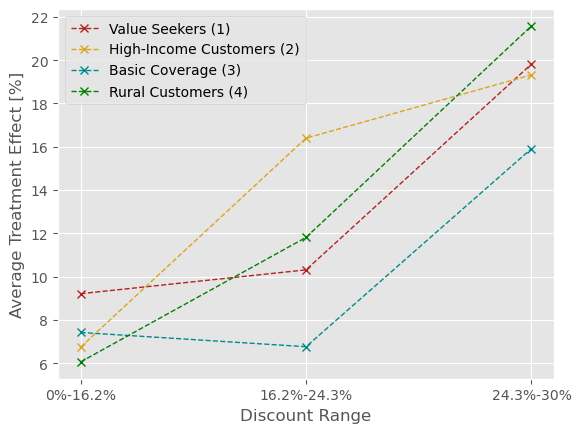

In [46]:
group_1 = [9.209, 10.312, 19.822]
group_2 = [6.740, 16.398, 19.323]
group_3 = [7.418, 6.760, 15.915]
group_4 = [6.057, 11.811, 21.584]

group_1_ci = 1.96 * np.array([2.293, 1.951, 1.664])
group_2_ci = 1.96 * np.array([2.517, 2.175, 1.842])

x = ["0%-16.2%", "16.2%-24.3%", "24.3%-30%"]

fig, ax = plt.subplots()
# ax.plot(x,y)
# ax.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

ax.plot(x, group_1, label="Value Seekers (1)", marker="x", linestyle='--', linewidth=1, color="firebrick")
# ax.fill_between(x, (group_1-group_1_ci), (group_1+group_1_ci), alpha=.1, color="firebrick")

ax.plot(x, group_2, label="High-Income Customers (2)", marker="x", linestyle='--', linewidth=1, color="goldenrod")
# ax.fill_between(x, (group_2-group_2_ci), (group_2+group_2_ci), alpha=.1, color="goldenrod")

ax.plot(x, group_3, label="Basic Coverage (3)", marker="x", linestyle='--', linewidth=1, color="darkcyan")
# ax.fill_between(x, (group_2-group_2_ci), (group_2+group_2_ci), alpha=.1, color="goldenrod")

ax.plot(x, group_4, label="Rural Customers (4)", marker="x", linestyle='--', linewidth=1, color="green")
# ax.fill_between(x, (group_2-group_2_ci), (group_2+group_2_ci), alpha=.1, color="goldenrod")

plt.xticks(x)
ax.legend()
plt.xlabel("Discount Range")
plt.ylabel("Average Treatment Effect [%]")
# plt.savefig('../plots/gate.png', dpi=200)
plt.show()

In [5]:
# i = 0

# for k_, v_ in double_mls.items():

#     if i == 0:
#         print(k_)
#         display(v_.summary)
#         features = [col for col in splits[k_].columns if col not in ['welcome_discount', 'churn']]
#         benchmark_sensitivities = {}

#         def process_feature(feature):
#             return feature, v_.sensitivity_benchmark(benchmarking_set=[feature])

#         results = Parallel(n_jobs=-1)(delayed(process_feature)(feature) for feature in features)

#         for feature, result in results:
#             benchmark_sensitivities[feature] = result

#         cf_y_lst = []
#         cf_d_lst = []
#         names = []
#         rhos = []

#         for k, v in benchmark_sensitivities.items():
#             cf_y_lst.append(v.loc["welcome_discount", "cf_y"])
#             cf_d_lst.append(v.loc["welcome_discount", "cf_d"])
#             rhos.append(v.loc["welcome_discount", "rho"])
#             names.append(k)

#         benchmark_dict = {
#             "cf_y" : cf_y_lst,
#             "cf_d" : cf_d_lst,
#             "name" : names
#         }

#         v_.sensitivity_analysis(cf_y=0.04, cf_d=0.03)
#         v_.sensitivity_plot(benchmarks=benchmark_dict)

#     i += 1

# print(f"Max cf_y: {np.max(cf_y_lst)}")
# print(f"Max cf_d: {np.max(cf_d_lst)}")
# print(f"Max rho: {np.max([np.abs(rho) for rho in rhos if np.abs(rho) != 1.0])}")